In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax
from dynamax.hidden_markov_model import CategoricalHMM
from flax import nnx
from jax import vmap
from jax.nn import one_hot
from tqdm import trange
import torch

import transformerlib
import rnnlib

In [2]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], [0.05, 0.95]])
emission_probs = jnp.array(
    [
        [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
    ]
)

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: (2, 2)
B.shape: (2, 6)


In [3]:
num_timesteps = 512  # Simulation length
num_states = 2  # two types of dice (fair and loaded)
num_emissions = 1  # only one die is rolled at a time
num_classes = 6  # each die has six faces

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
hmm_params, _ = hmm.initialize(
    initial_probs=initial_probs,
    transition_matrix=transition_matrix,
    emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes),
)

In [4]:
# == Generate training data == #
emissions = []
num_iterations = 1000
num_train_samples = 10000
num_test_samples = 100
num_timesteps = 512
batch_size = 32

train_states, train_emissions = jax.vmap(hmm.sample, in_axes=[None, 0, None])(
    hmm_params, jr.split(jr.PRNGKey(0), num_train_samples), num_timesteps
)
train_emissions = train_emissions[:, :, 0]

test_states, test_emissions = jax.vmap(hmm.sample, in_axes=[None, 0, None])(
    hmm_params, jr.split(jr.PRNGKey(1), num_test_samples), num_timesteps
)
test_emissions = test_emissions[:, :, 0]

In [5]:
# == Create Transformer Model == #
transformer_model = transformerlib.TransformerLM(
    vocab_size=6,
    d_embedding=64,
    max_seq_len=512,
    num_layers=1,
    d_model=64,
    num_heads=1,
    d_feedforward=128,
    attn_dropout_p=0.0,
    rngs=nnx.Rngs(params=jr.key(0), dropout=jr.key(1)),
)

# == Create Optimizer == #
learning_rate = 0.01
momentum = 0.9
transformer_optimizer = nnx.Optimizer(
    transformer_model, optax.adamw(learning_rate, momentum)
)

In [6]:
# == Create Recurrent Model == #
recurrent_model = rnnlib.LRUModel(
    dim_in=6, dim_hidden=64, dim_out=6, mlp_depth=3, num_layers=3, rngs=nnx.Rngs(0)
)

# == Create Optimizer == #
learning_rate = 0.005
momentum = 0.9
recurrent_optimizer = nnx.Optimizer(
    recurrent_model, optax.adamw(learning_rate, momentum)
)

In [7]:
# == Method to Sample Training/Test Data == #
def sample_emissions(sample_func, seed, batch_size, num_timesteps):
    """Sample a batch of data."""
    keys = jr.split(jr.key(seed), num=batch_size)
    return sample_func(keys, num_timesteps)[1][:, :, 0]


# == Method to Train/Update Model Parameters == #
# @partial(nnx.jit, static_argnums=(0, 1))
@nnx.jit
def train_step(model, optimizer, emissions):
    """Train for a single step."""

    # Create loss function for model `m` and emissions `e`
    def loss_fn(m, e):
        return optax.softmax_cross_entropy_with_integer_labels(
            logits=m(e[:, :-1]), labels=e[:, 1:]
        ).mean()

    # Use jax to compute the gradient of the parameters
    grad_fn = nnx.value_and_grad(loss_fn)

    # Evaluate the loss and gradients.
    loss, grads = grad_fn(model, emissions)

    # Update parameters, return loss
    optimizer.update(grads)
    return loss

In [8]:
# == Test the Pytorch implementation to double-check the JAX implementation == #

# pytorch_training_dataset = transformerlib.PytorchHMMDataset(
#     emissions=torch.from_numpy(np.array(train_emissions)),
#     states=torch.from_numpy(np.array(train_states)),
# )
# pytorch_dataset = torch.utils.data.DataLoader(
#     pytorch_training_dataset, batch_size=batch_size
# )
# pytorch_model = transformerlib.PytorchTransformerLM(
#     vocab_size=6,
#     d_embedding=64,
#     max_seq_len=512,
#     num_layers=1,
#     d_model=64,
#     num_heads=2,
#     d_feedforward=128,
# )
# if torch.cuda.is_available():
#     pytorch_model = pytorch_model.cuda()

# pytorch_optimizer = torch.optim.AdamW(
#     pytorch_model.parameters(), lr=learning_rate, weight_decay=momentum
# )
# pytorch_loss_fn = torch.nn.CrossEntropyLoss()
# pytorch_model.train()

# pytorch_loss_history = []
# num_iters_passed = 0
# while num_iters_passed < 1000:
#     for batch in pytorch_dataset:
#         if num_iters_passed >= 1000:
#             break
#         emissions, states = batch
#         emissions = emissions.long()
#         if torch.cuda.is_available():
#             emissions = emissions.cuda()
#             states = states.cuda()

#         cur_step = emissions[:, :-1]
#         next_step = emissions[:, 1:]
#         # For each time 't' through 'T-1', the transformer will learn to predict 't+1' given 0...'t'

#         # Forward pass
#         pytorch_optimizer.zero_grad()
#         logits = pytorch_model(cur_step)
#         loss = torch.nn.functional.cross_entropy(
#             logits.reshape(-1, num_classes), next_step.reshape(-1)
#         )

#         # Backward pass
#         loss.backward()
#         pytorch_optimizer.step()
#         pytorch_loss_history.append(loss.cpu().item())

#         num_iters_passed += 1

#         if num_iters_passed % 100 == 0:
#             print(f"PyTorch Iteration {num_iters_passed}: Loss {loss.cpu().item()}")


# pytorch_model.cpu().eval()
# pytorch_test_em = torch.from_numpy(np.array(test_emissions[1][None, ...]))
# pytorch_posterior = pytorch_model(pytorch_test_em[:, :-1])
# pytorch_posterior = (
#     torch.softmax(pytorch_posterior, dim=-1).detach().cpu().numpy().squeeze(0)
# )

# plt.figure()
# plt.plot(pytorch_posterior[:, -1], label="P(6)", color="red")
# plt.plot(pytorch_posterior[:, 0], label="P(1)", color="blue")
# plt.show()

In [9]:
# == Train jax RNN and Transformer == #
print("Training RNN")
recurrent_loss_history = []
for i in trange(num_iterations):
    idx = jr.randint(
        jr.PRNGKey(i), shape=(batch_size,), minval=0, maxval=train_emissions.shape[0]
    )
    recurrent_loss_history.append(
        train_step(recurrent_model, recurrent_optimizer, train_emissions[idx])
    )

print("Training Transformer")
transformer_loss_history = []
for i in trange(num_iterations):
    idx = jr.randint(
        jr.PRNGKey(i), shape=(batch_size,), minval=0, maxval=train_emissions.shape[0]
    )
    transformer_loss_history.append(
        train_step(transformer_model, transformer_optimizer, train_emissions[idx])
    )

Training RNN


100%|██████████| 1000/1000 [01:38<00:00, 10.16it/s]


Training Transformer


100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


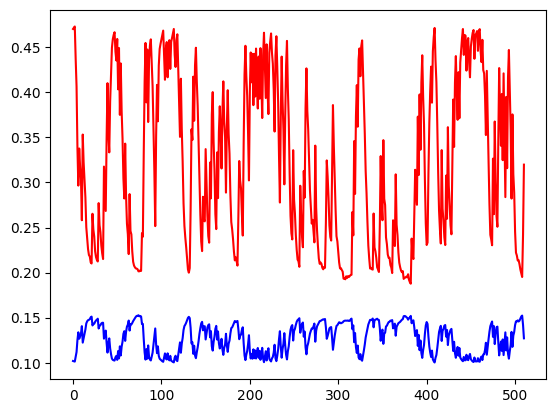

In [10]:
trial = 1
transformer_predicted_probs = jax.nn.softmax(
    transformer_model(test_emissions[trial][None, :-1]), axis=-1
).squeeze(0)
plt.plot(transformer_predicted_probs[:, -1], label="P(6)", color="red")
plt.plot(transformer_predicted_probs[:, 0], label="P(1)", color="blue")
plt.show()

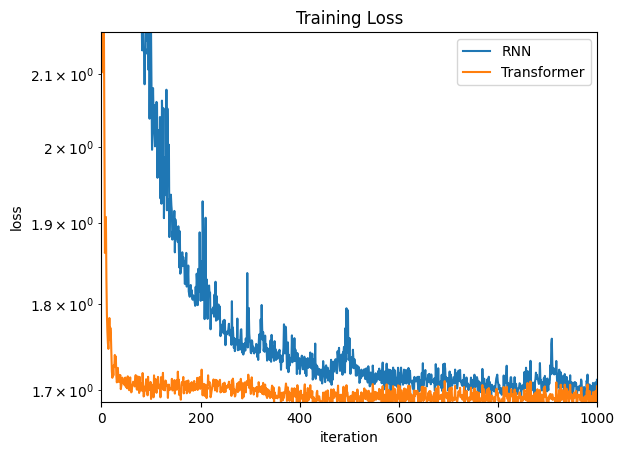

In [11]:
fig, ax = plt.subplots()
ax.plot(recurrent_loss_history, label="RNN")
ax.plot(transformer_loss_history, label="Transformer")
ax.set_yscale("log")
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
ax.legend()
ax.set_title("Training Loss")
ax.set_xlim(00, num_iterations)
ax.set_ylim(min(recurrent_loss_history), recurrent_loss_history[100])

plt.show()

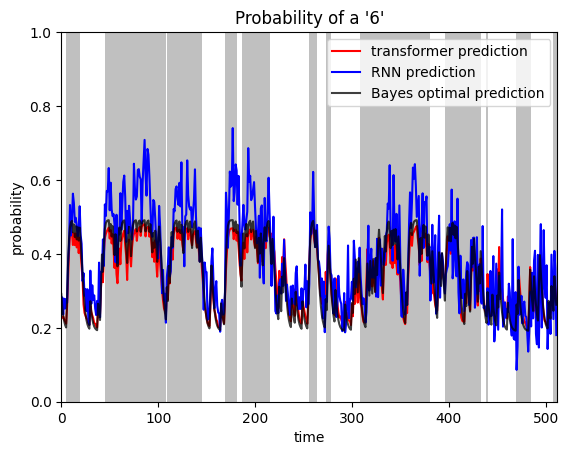

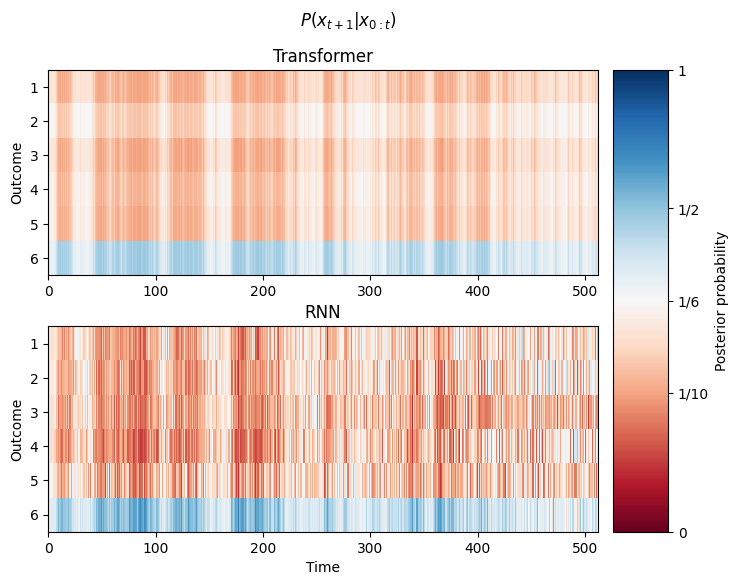

In [13]:
trial = 11
posterior = hmm.filter(hmm_params, test_emissions[trial])
transformer_predicted_probs = jax.nn.softmax(
    transformer_model(test_emissions[trial][None, ...]), axis=-1
).squeeze(0)
rnn_predicted_probs = jax.nn.softmax(
    recurrent_model(test_emissions[trial][None, ...]), axis=-1
).squeeze(0)

plt.figure()
plt.imshow(
    test_states[trial][None, :],
    extent=(0, num_timesteps, 0, 1),
    interpolation="none",
    aspect="auto",
    cmap="Greys",
    alpha=0.25,
)
plt.plot(
    transformer_predicted_probs[:, -1],  # Predicted probability of '6' at each timestep
    label="transformer prediction",
    color="red",
)
plt.plot(
    rnn_predicted_probs[:, -1],  # Predicted probability of '6' at each timestep
    label="RNN prediction",
    color="blue",
)
plt.plot(
    posterior.filtered_probs @ hmm_params.emissions.probs[:, 0, -1],
    label="Bayes optimal prediction",
    color="black",
    alpha=0.75,
)
plt.ylabel("probability")
plt.xlabel("time")
plt.title("Probability of a '6'")
plt.legend()
plt.show()


# Create a custom diverging color scaler
mapper = plt.cm.ScalarMappable(
    cmap="RdBu", norm=mpl.colors.TwoSlopeNorm(vcenter=1 / 6, vmin=0, vmax=1)
)

gs = mpl.gridspec.GridSpec(
    2, 2, width_ratios=[10, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.25
)
fig = plt.figure(figsize=(8, 6))

top = fig.add_subplot(gs[0, 0])  # Transformer plot
bottom = fig.add_subplot(gs[1, 0])  # RNN plot
cax = fig.add_subplot(gs[:, 1])  # colorbar

fig.suptitle("$P(x_{t+1} | x_{0:t})$")
top.set_title("Transformer")
transformer_image = mapper.to_rgba(transformer_predicted_probs.T)
im = top.imshow(
    transformer_image,
    aspect="auto",
    interpolation="none",
    extent=(0, num_timesteps, 6, 0),
)
top.set_ylabel("Outcome")
top.set_yticks(np.arange(0, 6) + 0.5)
top.set_yticklabels([1, 2, 3, 4, 5, 6])

bottom.set_title("RNN")
rnn_image = mapper.to_rgba(rnn_predicted_probs.T)
im = bottom.imshow(
    rnn_image,
    aspect="auto",
    interpolation="none",
    extent=(0, num_timesteps, 6, 0),
)
bottom.set_xlabel("Time")
bottom.set_ylabel("Outcome")
bottom.set_yticks(np.arange(0, 6) + 0.5)
bottom.set_yticklabels([1, 2, 3, 4, 5, 6])

# Add colorbar
cbar = fig.colorbar(mapper, cax=cax)
cbar.set_label("Posterior probability")
cbar.set_ticks([0, 0.1, 1 / 6, 1 / 2, 1])
cbar.set_ticklabels(["0", "1/10", "1/6", "1/2", "1"])
plt.show()
